In [4]:
# common stats analysis stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit
import scipy.stats as stats
import itertools
import pingouin as pg
import xarray as xr


#scikit learn
from sklearn.linear_model import LogisticRegression

# formulat interface to statsmodels (standard linear models)
import statsmodels.api as sm
import statsmodels.formula.api as smf
# BAyesian Model-building Interface (BAMBI)
import bambi as bmb
import arviz as az
# give me 0.95 HDIs as default
az.rcParams["stats.hdi_prob"] = 0.95

# for printing pretty tables and plots
from tabulate import tabulate
from  matplotlib.ticker import FuncFormatter, MaxNLocator

# some stuff for making notebooks look nice
from IPython.core.display import HTML, Markdown, display

# seed RNG
np.random.seed(0)

# hate these things
import warnings
warnings.filterwarnings("ignore")

# display all columns of dataframes
pd.set_option('display.max_columns', None)

# display x rows of dataframes
pd.set_option('display.max_rows', 30) # set to None to show all rows

#median for rts 
func_dict = {"Median": np.median,
            "MAD_SD":stats.median_abs_deviation,
             }


# package for saving variables into tex for publishing
from LaTeXDatax import datax

# import the data
exp_df = pd.read_csv("cleandata/exp-08-02-2022.csv")
qdf = pd.read_csv("cleandata/q-08-02-2022.csv")

In [5]:
# add some helpful columns to the df
# make sure the columns are coded as their proper data types
# 

df = exp_df.loc[:,~exp_df.columns.str.match("Unnamed")]

df["ruleInt"]=df["ruleInt"].astype("Int64")
df["ruleStr"]=df["ruleInt"].replace({1:"I",2:"II", 3:"III", 4:"IV", 5:"V", 6:"VI"})
df["ruleStr"]=df["ruleStr"].astype("category")
# df["hit"] = df["hitormiss"].astype(int)
df["hitStr"]=df["hitormiss"].replace({False:"0",True:"1"}).astype("category")
df["subjid"]=df["subjid"].astype("category")
df["game"]=df["game"].astype("Int64")
df["trial"]=df["trial"].astype("Int64")

testdf = df.loc[(df["phase"]=="test")]
learndf = df.loc[(df["phase"]=="learn")]
taskdf = df.loc[(df["phase"]=="task")]

display(df.head())

,phase,subjid,incentive,rule,dimorder,dimvals,condition,counterbalance,block,trial,nrepeats,theorystim,actualstim,correct,resp,hitormiss,rt,testscore,timestop,lasttwodigits,bonusprob,bonus,ruleInt,ruleStr,expNum,iid,answervalue,game,ticketvalue,ticketcolor,blocktrial,bonustodate,totalbonustodate,ntrials,points,allcards,moreA,scoretodate,score,bonusvalue,win,hitStr
0,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,1,2.0,6.0,5.0,0.0,0.0,True,3589.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,2,2.0,4.0,7.0,1.0,0.0,False,10256.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,3,2.0,7.0,4.0,0.0,0.0,True,11863.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,4,2.0,7.0,4.0,0.0,0.0,True,5234.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,5,2.0,5.0,6.0,0.0,1.0,False,4442.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
# formatting for consistent and beautiful coloring. for default/no hues, use color="b" (black)
# mypalette = ["#66c2a5","#8da0cb","#e78ac3","#fc8d62","#a6d854","#ffd92f"]
# mypalette = ["#1b9e77","#d95f02","#e7298a","#7570b3","#66a61e","#e6ab02"]
mypalette=["#264653","#2a9d8f","#e9d8a6","#ee9b00","#bb3e03","#9b2226"]
sns.set_palette(mypalette)
pal = sns.color_palette(mypalette)

# where axis is like ax.xaxis or ax.yaxis
def integerize_ticks(axis):
    axis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

def plot_performance_over_rule(ax):
    ax.set_ylabel("Percent correct")
    ax.set_ylim([0.0,1])
    ax.axhline(0.5, ls='--',color="lightgrey",zorder=0)
    ax.set_xlabel("Categorization Rule Type")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x+1))) # here we add one since rule is 0 indexed
    
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Mixed logistic regression

### Experiment 1

In [8]:
# experiment 1 (0)
testdata0 = testdf.loc[testdf["expNum"]==0][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata0 = learndf.loc[learndf["expNum"]==0][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

testdata0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 16 to 10449
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   subjid     3344 non-null   category
 1   trial      3344 non-null   Int64   
 2   ruleStr    3344 non-null   category
 3   incentive  3344 non-null   float64 
 4   hitStr     3344 non-null   category
 5   rt         3344 non-null   float64 
dtypes: Int64(1), category(3), float64(2)
memory usage: 140.6 KB


In [9]:
# ------- performance by rule
print("Performance by rule and incentive")

model0 = bmb.Model('hitStr["1"] ~ 0 + ruleStr * incentive', testdata0, family="bernoulli")
print(model0)
results0 = model0.fit(draws=1000, chains=4)
coefs0 = az.summary(results0)
coefs0

Performance by rule and incentive
Formula: hitStr["1"] ~ 0 + ruleStr * incentive
Family name: Bernoulli
Link: logit
Observations: 3344
Priors:
  Common-level effects
    ruleStr ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [6.6577 6.5848 6.9877 6.5848 7.1302 6.417 ])
    incentive ~ Normal(mu: 0.0, sigma: 0.2078)
    ruleStr:incentive ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [0.3159 0.3275 0.3099 0.3419 0.3235])


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [ruleStr, incentive, ruleStr:incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ruleStr[I],2.208,0.255,1.691,2.684,0.007,0.005,1182.0,1937.0,1.0
ruleStr[II],1.390,0.169,1.069,1.731,0.003,0.002,4521.0,2837.0,1.0
ruleStr[III],1.102,0.184,0.730,1.452,0.003,0.002,4228.0,2593.0,1.0
ruleStr[IV],1.440,0.174,1.086,1.767,0.003,0.002,3309.0,2861.0,1.0
ruleStr[V],1.148,0.166,0.830,1.468,0.003,0.002,3860.0,2868.0,1.0
ruleStr[VI],0.605,0.139,0.318,0.862,0.002,0.001,4398.0,2904.0,1.0
incentive,0.016,0.013,-0.008,0.043,0.000,0.000,825.0,1150.0,1.0
ruleStr:incentive[II],-0.026,0.015,-0.055,0.005,0.000,0.000,984.0,1639.0,1.0
ruleStr:incentive[III],-0.027,0.016,-0.059,0.002,0.000,0.000,1021.0,1609.0,1.0
ruleStr:incentive[IV],-0.026,0.015,-0.054,0.006,0.000,0.000,1018.0,1773.0,1.0


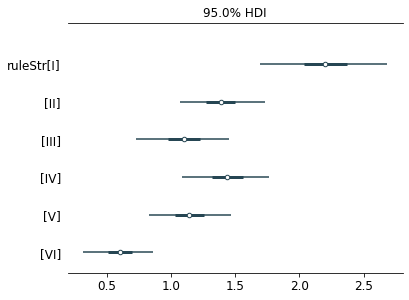

In [12]:
ax = az.plot_forest(
    results0,
    var_names=["ruleStr"],
    combined=True
)

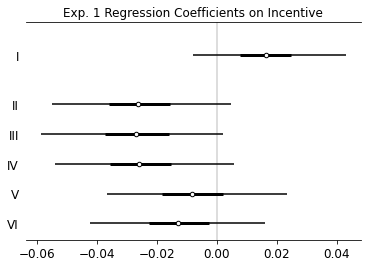

In [30]:
fig, ax = plt.subplots()

az.plot_forest(
    results0,
    var_names=["incentive"],
    filter_vars="regex",
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax
)

#reverse since it labels from bottom to top
# ax.set_yticklabels(["Incentive: I","Incentive: II","Incentive: III","Incentive: IV","Incentive: V","Incentive: VI"].reverse())
ax.set_yticklabels(["I","II","III","IV","V","VI"][::-1])
ax.set_title("Exp. 1 Regression Coefficients on Incentive")
ax.axvline(0,color="lightgrey",zorder=0)


In [ ]:
# combo = results0.posterior["incentive"] + results0.posterior["ruleStr:incentive"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=6,figsize=(18,4))
# az.plot_posterior(results0.posterior["incentive"], hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])
# az.plot_posterior(combo[:,:,2], hdi_prob=0.95, ref_val=0, ax=axes[3])
# az.plot_posterior(combo[:,:,3], hdi_prob=0.95, ref_val=0, ax=axes[4])
# az.plot_posterior(combo[:,:,4], hdi_prob=0.95, ref_val=0, ax=axes[5])

# fig.suptitle("Exp 1 Estimate of incentive slope on Performance")

# axes[0].set_title("Rule Type I")
# axes[1].set_title("Rule Type II")
# axes[2].set_title("Rule Type III")
# axes[3].set_title("Rule Type IV")
# axes[4].set_title("Rule Type V")
# axes[5].set_title("Rule Type VI")

In [ ]:
# results0.posterior["incentive"]
# results0stacked = results0.stack(sample=["chain", "draw"])
# combo = results0stacked.posterior["incentive"] + results0stacked.posterior["ruleStr:incentive"] #.stack(samples=("chain", "draw"))

# results0stacked.posterior["incentive"], combo[:,0], combo[:,1], combo[:,2], combo[:,3], combo[:,4]

In [ ]:
# ax = az.plot_forest(
#     [results0stacked.posterior["incentive"], combo[:,0], combo[:,1], combo[:,2], combo[:,3], combo[:,4]],
#     model_names=["I","II", "III","IV","V","VI"],
# )

# ax = az.plot_forest(
#     results0,
#     var_names=["Intercept","ruleStr"],
#      combined=True
# )

In [ ]:
# ------- response time
print("Response time by incentive")

model0rt_test = bmb.Model('rt ~ 0 + incentive * ruleStr', testdata0)
results0rt_test = model0rt_test.fit(draws=1000, chains=4)
az.summary(results0rt_test, stat_funcs=func_dict, extend=True)

In [ ]:
print("LEARNING phase response time data")
model0rt_learn = bmb.Model('rt ~ 0 + incentive * ruleStr', learndata0)
results0rt_learn = model0rt_learn.fit(draws=1000, chains=4)
az.summary(results0rt_learn, stat_funcs=func_dict, extend=True)

### Experiment 2

In [ ]:
# experiment 2
print("EXPERIMENT 2")

# experiment 2 (1)
testdata1 = testdf.loc[testdf["expNum"]==1][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata1 = learndf.loc[learndf["expNum"]==1][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

# ------- performance by incentive
model1 = bmb.Model('hitStr["1"] ~ 0 + ruleStr * incentive', testdata1, family="bernoulli")
print(model1)
results1 = model1.fit(draws=1000, chains=4)
az.summary(results1)



In [ ]:
# ------- reaction time
print("Response time by incentive")

model1rt_test = bmb.Model('rt ~ 0 + incentive * ruleStr', testdata1)
results1rt_test = model1rt_test.fit(draws=1000, chains=4)
az.summary(results1rt_test, stat_funcs=func_dict, extend=True)


In [ ]:
print("LEARNING phase response time data")
model1rt_learn = bmb.Model('rt ~ 0 + incentive * ruleStr', learndata1)
results1rt_learn = model1rt_learn.fit(draws=1000, chains=4)
az.summary(results1rt_learn, stat_funcs=func_dict, extend=True)

### Experiment 3

In [ ]:
# experiment 3

# experiment 3 (2)
testdata2 = testdf.loc[testdf["expNum"]==2][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata2 = learndf.loc[learndf["expNum"]==2][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

# ------- performance by incentive
model2 = bmb.Model('hitStr["1"] ~ 0 + ruleStr * incentive', testdata2, family="bernoulli")
print(model2)
results2 = model2.fit(draws=1000, chains=4)
az.summary(results2)

In [ ]:
# combo = results2.posterior["incentive"] + results2.posterior["ruleStr:incentive"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# az.plot_posterior(results2.posterior["incentive"], hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# # az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

# fig.suptitle("Exp 3 Estimate of incentive slope on Performance")

# axes[0].set_title("Rule Type II")
# axes[1].set_title("Rule Type IV")

In [ ]:
# ------- reaction time
print("Response time by incentive")

model2rt_test = bmb.Model('rt ~ 0 + incentive * ruleStr', testdata2)
results2rt_test = model2rt_test.fit(draws=1000, chains=4)
az.summary(results2rt_test, stat_funcs=func_dict, extend=True)

In [ ]:
# combo = results2rt_test.posterior["incentive"] + results2rt_test.posterior["incentive:ruleStr"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# az.plot_posterior(results2rt_test.posterior["incentive"], point_estimate="median", hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo, hdi_prob=0.95, point_estimate="median", ref_val=0, ax=axes[1])
# # az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

# fig.suptitle("Exp 3 Estimate of incentive slope on RT Test phase")

# axes[0].set_title("Rule Type II")
# axes[1].set_title("Rule Type IV")

In [ ]:
print("LEARNING phase response time data")
model2rt_learn = bmb.Model('rt ~ 0 + incentive * ruleStr', learndata2)
results2rt_learn = model2rt_learn.fit(draws=1000, chains=4)
az.summary(results2rt_learn, stat_funcs=func_dict, extend=True)

In [ ]:
# combo = results2rt_learn.posterior["incentive"] + results2rt_learn.posterior["incentive:ruleStr"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# az.plot_posterior(results2rt_learn.posterior["incentive"], hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# # az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

# fig.suptitle("Exp 3 Estimate of incentive slope on RT Learn phase")

# axes[0].set_title("Rule Type II")
# axes[1].set_title("Rule Type IV")

### Experiment 4

WITHIN SUBJECTS. Each subj performs 4 blocks. Low vs High incentive crossed with Rule type II and IV.

TODO: This regression needs to consider the subject-level data accounting for the within design

In [ ]:
# experiment 4
# WITHIN SUBJECTS, so data frame looks a little different - each subject does 4 blocks

# experiment 4 (3)
testdata3 = testdf.loc[testdf["expNum"]==3][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]
learndata3 = learndf.loc[learndf["expNum"]==3][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]

# ------- performance by incentive
model3 = bmb.Model('hitStr["1"] ~ 0 + ruleStr * ticketvalue + (0 + ruleStr|subjid) + (ticketvalue|subjid)', testdata3, family="bernoulli")
print(model3)
results3 = model3.fit(draws=1000, chains=4)
az.summary(results3)


In [ ]:
# combo = results3.posterior["ticketvalue"] + results3.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# az.plot_posterior(results3.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# # az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

# fig.suptitle("Exp 4 Estimate of incentive slope on Performance")

# axes[0].set_title("Rule Type II")
# axes[1].set_title("Rule Type IV")

In [ ]:
# # ------- performance by game
# print(testdata3["game"].unique())
# model3game = bmb.Model('hitStr["1"] ~ game + (game|subjid)', testdata3, family="bernoulli")
# print(model3game)
# results3game = model3game.fit(draws=1000, chains=4)
# az.summary(results3game)


In [ ]:
# ------- reaction time
print("Response time by incentive")

model3rt_test = bmb.Model('rt ~ 0 + ruleStr * ticketvalue + (0 + ruleStr|subjid) + (ticketvalue|subjid)', testdata3)
results3rt_test = model3rt_test.fit(draws=1000, chains=4)
az.summary(results3rt_test, stat_funcs=func_dict, extend=True)

In [ ]:
# combo = results3rt_test.posterior["ticketvalue"] + results3rt_test.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# az.plot_posterior(results3rt_test.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# # az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

# fig.suptitle("Exp 4 Estimate of incentive slope on RT in test phase")

# axes[0].set_title("Rule Type II")
# axes[1].set_title("Rule Type IV")
# # axes[2].set_title("Rule Type IV")

In [ ]:
# ------- reaction time
print("Response time in learning phase")

model3rt_learn = bmb.Model('rt ~ 0 + ruleStr * ticketvalue + (0 + ruleStr|subjid) + (ticketvalue|subjid)', learndata3)
results3rt_learn = model3rt_learn.fit(draws=1000, chains=4)
az.summary(results3rt_learn, stat_funcs=func_dict, extend=True)

In [ ]:
# combo = results3rt_learn.posterior["ticketvalue"] + results3rt_learn.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# az.plot_posterior(results3rt_learn.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# # az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

# fig.suptitle("Estimate of incentive slope on RT in learning phase")

# # axes[0].set_title("Rule Type I")
# axes[0].set_title("Rule Type II")
# axes[1].set_title("Rule Type IV")

### Experiment 5

category recognition task (no discovery)
once again, incentive is varied within subject

In [ ]:
# experiment 5 (4)
taskdata4 = taskdf.loc[taskdf["expNum"]==4][["subjid","trial","ruleStr","points","hitStr","rt"]]
# learndata4 = learndf.loc[learndf["expNum"]==4][["subjid","trial","ruleStr","ticketvalue","hitStr","rt"]]

taskdata4.head()


In [ ]:
# ------- performance by incentive
model4 = bmb.Model('hitStr["1"] ~ 0 + ruleStr * points + (points|subjid)', taskdata4, family="bernoulli")
print(model4)
results4 = model4.fit(draws=1000, chains=4)
coefs4 = az.summary(results4)
coefs4

In [ ]:
# allsubjs = taskdata4["subjid"].unique()

# # do this to get the index of the subject (e.g., from between 0 and N=200 rather than the arbitrary subject id numbers that skip excluded subjs)
# r1subjids = np.array([str(i) for i in taskdata4.query("ruleStr=='I'")["subjid"].unique()])
# # r1subjs=[str(i) for i, x in enumerate(allsubjs) if x in r1subjids]
# # print(r1subjids)

# r2subjids = np.array([str(i) for i in taskdata4.query("ruleStr=='II'")["subjid"].unique()])

# r4subjids = np.array([str(i) for i in taskdata4.query("ruleStr=='IV'")["subjid"].unique()])

# # print(posterior["1|subjid"].sel(subjid__factor_dim=r1subjids))
# # posterior

In [ ]:

# incentive = np.array([0,32])
# # print(incentive)

# posterior = az.extract_dataset(results4)

# # Intercept common
# r1_common = posterior["Intercept"] 
# r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
# r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# # slope common
# r1_slope_common = posterior["points"]
# r2_slope_common = posterior["points"] + posterior["ruleStr:points"][0]
# r4_slope_common = posterior["points"] + posterior["ruleStr:points"][1]

# # intercept group specific
# # rule_group_specific = posterior["1|subjid"] # separate by rule type
# r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
# r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
# r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# # slope group specific
# r1_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r1subjids)
# r2_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r2subjids)
# r4_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r4subjids)

# a1 = r1_common.mean() + r1_group.mean("sample")
# b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

# a2 = r2_common.mean() + r2_group.mean("sample")
# b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

# a4 = r4_common.mean() + r4_group.mean("sample")
# b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

# incentive_xi = xr.DataArray(incentive)

# fig, ax = plt.subplots()
# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color="#264653", lw=4),
#                 Line2D([0], [0], color="#2a9d8f", lw=4),
#                 Line2D([0], [0], color="#ee9b00", lw=4)]

# # # all subjects individual curves
# # plt.plot(incentive, expit(a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# # plt.plot(incentive, expit(a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# # plt.plot(incentive, expit(a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# # standard deviation bars
# plt.fill_between(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi - r1_common.std() - r1_slope_common.std()* incentive_xi).T, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi + r1_common.std() + r1_slope_common.std() * incentive_xi).T, color="#264653", alpha=0.2)
# plt.fill_between(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi - r2_common.std() - r2_slope_common.std()* incentive_xi).T, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi + r2_common.std() + r2_slope_common.std() * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi - r4_common.std() - r4_slope_common.std()* incentive_xi).T, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi + r4_common.std() + r4_slope_common.std() * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # # HDI bars
# # plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["points","hdi_3%"] * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["points","hdi_97%"] * incentive_xi).T, color="#264653", alpha=0.2)
# # plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[II]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[II]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[II]","hdi_97%"] + coefs4.loc["ruleStr:points[II]","hdi_97%"] * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# # plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[IV]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[IV]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[IV]","hdi_97%"] + coefs4.loc["ruleStr:points[IV]","hdi_97%"] * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # horizontal line at 0.5
# # plt.plot([0,32],[0.5,0.5], ls='--',color="darkgrey",zorder=0, lw=2)

# # average curves
# plt.plot(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi).T, color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi).T, color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi).T, color="#ee9b00", alpha=1, lw=4)

# plt.ylim([0.5,1.0])
# # 

# plt.ylabel("Predicted % correct")
# plt.xlabel("Points")
# ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# # plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

# plt.show()

In [ ]:
# ------- performance by incentive

taskdata4["logpoints"] = np.log(taskdata4["points"]+1)
taskdata4

model4log = bmb.Model('hitStr["1"] ~ 0 + ruleStr * logpoints + (logpoints|subjid)', taskdata4, family="bernoulli")
print(model4log)
results4log = model4log.fit(draws=1000, chains=4)
coefs4log = az.summary(results4log)
coefs4log


In [ ]:
# incentive = np.array([0,32])
# # print(incentive)

# posterior = az.extract_dataset(results4log)

# # Intercept common
# r1_common = posterior["Intercept"] 
# r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
# r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# # slope common
# r1_slope_common = posterior["logpoints"]
# r2_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][0]
# r4_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][1]

# # intercept group specific
# # rule_group_specific = posterior["1|subjid"] # separate by rule type
# r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
# r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
# r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# # slope group specific
# r1_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r1subjids)
# r2_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r2subjids)
# r4_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r4subjids)

# a1 = r1_common.mean() + r1_group.mean("sample")
# b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

# a2 = r2_common.mean() + r2_group.mean("sample")
# b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

# a4 = r4_common.mean() + r4_group.mean("sample")
# b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

# incentive_xi = xr.DataArray(incentive)

# fig, ax = plt.subplots()
# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color="#264653", lw=4),
#                 Line2D([0], [0], color="#2a9d8f", lw=4),
#                 Line2D([0], [0], color="#ee9b00", lw=4)]

# # # all subjects individual curves
# # plt.plot(incentive, expit(a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# # plt.plot(incentive, expit(a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# # plt.plot(incentive, expit(a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# # # standard deviation bars
# # plt.fill_between(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi - r1_common.std() - r1_slope_common.std()* incentive_xi).T, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi + r1_common.std() + r1_slope_common.std() * incentive_xi).T, color="#264653", alpha=0.2)
# # plt.fill_between(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi - r2_common.std() - r2_slope_common.std()* incentive_xi).T, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi + r2_common.std() + r2_slope_common.std() * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# # plt.fill_between(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi - r4_common.std() - r4_slope_common.std()* incentive_xi).T, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi + r4_common.std() + r4_slope_common.std() * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # # HDI bars
# # plt.fill_between(incentive_xi, expit(coefs4log.loc["Intercept","hdi_3%"] + coefs4log.loc["points","hdi_3%"] * incentive_xi).T, expit(coefs4log.loc["Intercept","hdi_97%"] + coefs4.loc["points","hdi_97%"] * incentive_xi).T, color="#264653", alpha=0.2)
# # plt.fill_between(incentive_xi, expit(coefs4log.loc["Intercept","hdi_3%"] + coefs4log.loc["ruleStr[II]","hdi_3%"] + (coefs4log.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[II]","hdi_3%"]) * incentive_xi).T, expit(coefs4log.loc["Intercept","hdi_97%"] + coefs4log.loc["ruleStr[II]","hdi_97%"] + coefs4log.loc["ruleStr:points[II]","hdi_97%"] * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# # plt.fill_between(incentive_xi, expit(coefs4log.loc["Intercept","hdi_3%"] + coefs4log.loc["ruleStr[IV]","hdi_3%"] + (coefs4log.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[IV]","hdi_3%"]) * incentive_xi).T, expit(coefs4log.loc["Intercept","hdi_97%"] + coefs4log.loc["ruleStr[IV]","hdi_97%"] + coefs4log.loc["ruleStr:points[IV]","hdi_97%"] * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # horizontal line at 0.5
# # ax.axhline(0.5, ls='--',color="darkgrey",zorder=0, lw=2)

# # average curves
# # plt.plot(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * (incentive_xi)).T, color="#264653", alpha=1, lw=4)
# # plt.plot(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * (incentive_xi)).T, color="#2a9d8f", alpha=1, lw=4)
# # plt.plot(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * (incentive_xi)).T, color="#ee9b00", alpha=1, lw=4)

# # linear in log space
# # plt.plot(np.log1p(incentive_xi), expit(r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi)).T, color="#264653", alpha=1, lw=4)
# # plt.plot(np.log1p(incentive_xi), expit(r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T, color="#2a9d8f", alpha=1, lw=4)
# # plt.plot(np.log1p(incentive_xi), expit(r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T, color="#ee9b00", alpha=1, lw=4)

# # logistic in linear space
# # r1term= ((incentive_xi + 1) ** r1_slope_common.mean()) * np.exp(r1_common.mean())
# # plt.plot(incentive_xi, (r1term/(1+r1term)).T, color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(np.expm1(r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi)).T), color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(np.expm1(r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T), color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(np.expm1(r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T), color="#ee9b00", alpha=1, lw=4)
# # plt.plot(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T, color="#2a9d8f", alpha=1, lw=4)
# # plt.plot(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T, color="#ee9b00", alpha=1, lw=4)

# plt.ylim([0.5,1.0])
# # 

# plt.ylabel("probability correct")
# plt.xlabel("log incentive log(points + 1)")
# ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# # plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

# plt.show()

In [ ]:
# combo = results4.posterior["points"] + results4.posterior["ruleStr:points"] #.stack(samples=("chain", "draw"))
# # comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
# fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
# az.plot_posterior(results4.posterior["points"], hdi_prob=0.95, ref_val=0, ax=axes[0])
# az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

# fig.suptitle("Exp. 5 - Estimate of incentive slope on performance")

# axes[0].set_title("Rule Type I")
# axes[1].set_title("Rule Type II")
# axes[2].set_title("Rule Type IV")

In [ ]:
# ------- reaction time
print("Response time by incentive")

model4rt = bmb.Model('rt ~ 0 + ruleStr * points + (points|subjid)', taskdata4)
results4rt = model4rt.fit(draws=1000, chains=4)
az.summary(results4rt, stat_funcs=func_dict, extend=True)

In [ ]:
combo = results4rt.posterior["points"] + results4rt.posterior["ruleStr:points"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
az.plot_posterior(results4rt.posterior["points"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp. 5 - Estimate of incentive slope on RT")

axes[0].set_title("Rule Type I")
axes[1].set_title("Rule Type II")
axes[2].set_title("Rule Type IV")

In [ ]:
incentive = np.array([0,32])
# print(incentive)

posterior = az.extract_dataset(results4rt)

# Intercept common
r1_common = posterior["Intercept"] 
r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# slope common
r1_slope_common = posterior["points"]
r2_slope_common = posterior["points"] + posterior["ruleStr:points"][0]
r4_slope_common = posterior["points"] + posterior["ruleStr:points"][1]

# intercept group specific
# rule_group_specific = posterior["1|subjid"] # separate by rule type
r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# slope group specific
r1_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r1subjids)
r2_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r2subjids)
r4_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r4subjids)

a1 = r1_common.mean() + r1_group.mean("sample")
b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

a2 = r2_common.mean() + r2_group.mean("sample")
b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

a4 = r4_common.mean() + r4_group.mean("sample")
b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

incentive_xi = xr.DataArray(incentive)

fig, ax = plt.subplots()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#264653", lw=4),
                Line2D([0], [0], color="#2a9d8f", lw=4),
                Line2D([0], [0], color="#ee9b00", lw=4)]

# # all subjects individual curves
# plt.plot(incentive, (a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# plt.plot(incentive, (a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# plt.plot(incentive, (a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# standard deviation bars
plt.fill_between(incentive_xi, .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi - r1_common.std() - r1_slope_common.std()* incentive_xi).T,
 .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi + r1_common.std() + r1_slope_common.std() * incentive_xi).T, color="#264653", alpha=0.2)
plt.fill_between(incentive_xi, .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi - r2_common.std() - r2_slope_common.std()* incentive_xi).T,
 .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi + r2_common.std() + r2_slope_common.std() * incentive_xi).T, color="#2a9d8f", alpha=0.2)
plt.fill_between(incentive_xi, .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi - r4_common.std() - r4_slope_common.std()* incentive_xi).T,
 .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi + r4_common.std() + r4_slope_common.std() * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # HDI bars
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["points","hdi_3%"] * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["points","hdi_97%"] * incentive_xi).T, color="#264653", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[II]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[II]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[II]","hdi_97%"] + coefs4.loc["ruleStr:points[II]","hdi_97%"] * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[IV]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[IV]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[IV]","hdi_97%"] + coefs4.loc["ruleStr:points[IV]","hdi_97%"] * incentive_xi).T, color="#ee9b00", alpha=0.2)

# horizontal line at 0.5
# plt.plot([0,32],[0.5,0.5], ls='--',color="darkgrey",zorder=0, lw=2)

# average curves
plt.plot(incentive_xi, .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi).T, color="#264653", alpha=1, lw=4)
plt.plot(incentive_xi, .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi).T, color="#2a9d8f", alpha=1, lw=4)
plt.plot(incentive_xi, .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi).T, color="#ee9b00", alpha=1, lw=4)

# plt.ylim([0.5,1.0])
# 

plt.ylabel("Predicted response time (s)")
plt.xlabel("Points")
ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

plt.show()

In [ ]:
# ------- reaction time
print("Response time by incentive")

model4rtlog = bmb.Model('rt ~ ruleStr * logpoints + (logpoints|subjid)', taskdata4)
results4rtlog = model4rtlog.fit(draws=1000, chains=4)
az.summary(results4rtlog, stat_funcs=func_dict, extend=True)

In [ ]:
incentive = np.array([0,32])
# print(incentive)

posterior = az.extract_dataset(results4rtlog)

# Intercept common
r1_common = posterior["Intercept"] 
r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# slope common
r1_slope_common = posterior["logpoints"]
r2_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][0]
r4_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][1]

# intercept group specific
# rule_group_specific = posterior["1|subjid"] # separate by rule type
r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# slope group specific
r1_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r1subjids)
r2_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r2subjids)
r4_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r4subjids)

a1 = r1_common.mean() + r1_group.mean("sample")
b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

a2 = r2_common.mean() + r2_group.mean("sample")
b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

a4 = r4_common.mean() + r4_group.mean("sample")
b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

incentive_xi = xr.DataArray(incentive)

fig, ax = plt.subplots()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#264653", lw=4),
                Line2D([0], [0], color="#2a9d8f", lw=4),
                Line2D([0], [0], color="#ee9b00", lw=4)]

# # all subjects individual curves
# plt.plot(incentive, (a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# plt.plot(incentive, (a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# plt.plot(incentive, (a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# # standard deviation bars
# plt.fill_between(np.log1p(incentive_xi), .001 * (r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi) - r1_common.std() - r1_slope_common.std()* np.log1p(incentive_xi)).T,
#  .001 * (r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi) + r1_common.std() + r1_slope_common.std() * np.log1p(incentive_xi)).T, color="#264653", alpha=0.2)
# plt.fill_between(np.log1p(incentive_xi), .001 * (r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi) - r2_common.std() - r2_slope_common.std()* np.log1p(incentive_xi)).T,
#  .001 * (r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi) + r2_common.std() + r2_slope_common.std() * np.log1p(incentive_xi)).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(np.log1p(incentive_xi), .001 * (r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi) - r4_common.std() - r4_slope_common.std()* np.log1p(incentive_xi)).T,
#  .001 * (r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi) + r4_common.std() + r4_slope_common.std() * np.log1p(incentive_xi)).T, color="#ee9b00", alpha=0.2)


# average curves
# plt.plot(incentive_xi, .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi).T, color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi).T, color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi).T, color="#ee9b00", alpha=1, lw=4)
# linear in log space
plt.plot(np.log1p(incentive_xi), (.001 * (r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi)).T), color="#264653", alpha=1, lw=4)
plt.plot(np.log1p(incentive_xi), (.001 * (r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T), color="#2a9d8f", alpha=1, lw=4)
plt.plot(np.log1p(incentive_xi), (.001 * (r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T), color="#ee9b00", alpha=1, lw=4)
# plt.plot(incentive_xi, (.001 * (r1_common.mean() + r1_slope_common.mean() * (incentive_xi)).T), color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, (.001 * (r2_common.mean() + r2_slope_common.mean() * (incentive_xi)).T), color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, (.001 * (r4_common.mean() + r4_slope_common.mean() * (incentive_xi)).T), color="#ee9b00", alpha=1, lw=4)


plt.ylabel("Predicted response time (s)")
plt.xlabel("log Points")
ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

plt.show()

EXPERIMENT 6

In [ ]:
# EXPERIMENT 6 (5)

testdata5 = testdf.loc[testdf["expNum"]==5][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]
learndata5 = learndf.loc[learndf["expNum"]==5][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]

# ------- performance by incentive
model5a = bmb.Model('hitStr["1"] ~ ruleStr * ticketvalue + (ticketvalue|subjid)', testdata5, family="bernoulli")
print(model5a)
results5a = model5a.fit(draws=1000, chains=4)
az.summary(results5a)

In [ ]:
az.plot_posterior(results5a, var_names=["Intercept","ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [ ]:
combo = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
az.plot_posterior(results5a.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Estimate of incentive slope")

axes[0].set_title("Rule Type I")
axes[1].set_title("Rule Type II")
axes[2].set_title("Rule Type IV")



In [ ]:
# ------- performance by incentive
model5b = bmb.Model('hitStr["1"] ~ 0 + ruleStr * ticketvalue + (ticketvalue|subjid)', testdata5, family="bernoulli")
print(model5b)
results5b = model5b.fit(draws=1000, chains=4)
az.summary(results5b)

In [ ]:
az.plot_posterior(results5b, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [ ]:
# ------- reaction time
print("Response time by incentive")

model5rt_test = bmb.Model('rt ~ ruleStr * ticketvalue + (ticketvalue|subjid)', testdata5)
results5rt_test = model5rt_test.fit(draws=1000, chains=4)
az.summary(results5rt_test, stat_funcs=func_dict, extend=True)

In [ ]:
az.plot_posterior(results5rt_test, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [ ]:
# ------- reaction time
print("Response time in learning phase")

model5rt_learn = bmb.Model('rt ~ ruleStr * ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', learndata5)
results5rt_learn = model5rt_learn.fit(draws=1000, chains=4)
az.summary(results5rt_learn, stat_funcs=func_dict, extend=True)

az.plot_posterior(results5rt_learn, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [ ]:
az.summary(results5rt_learn, stat_funcs=func_dict, extend=True)
az.plot_posterior(results5rt_learn, var_names=["Intercept","ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [ ]:

# def get_predictions(model, idata, seq, rule):
#     # subids = testdata5.query("ruleStr=='"+rule+"'")['subjid'].unique()


#     # Create a data frame with the new data
#     new_data = pd.DataFrame({"ticketvalue": seq, "ruleStr": rule})

#     # Predict probability of dying using out of sample data
#     model.predict(idata, data=new_data)

#     # Stack chains and draws
#     posterior = idata.posterior["hitStr_mean"].stack(samples=("chain", "draw"))
#     # Get posterior mean across all draws
#     mu = posterior.mean(axis=1)
#     return mu

# x_seq = np.linspace(0, 2, num=200)
# # inverse of the logit function

# mu_logit_1 = get_predictions(model5group, results5group, x_seq, "I")
# mu_logit_2 = get_predictions(model5group, results5group, x_seq, "II")
# mu_logit_4 = get_predictions(model5group, results5group, x_seq, "IV")


# plt.plot(x_seq, mu_logit_1, lw=2, label="I")
# plt.plot(x_seq, mu_logit_2, lw=2, label="II")
# plt.plot(x_seq, mu_logit_4, lw=2, label="IV")
# plt.axhline(0.5, c="k", alpha=0.5, ls="--")
# plt.xlabel("Incentive")
# plt.ylabel("Probability correct")
# plt.legend();


In [ ]:
# t-tests

bonus_df = df.loc[(df["phase"]=="bonus") & (df["expNum"]==5)]
bonus_df = bonus_df[['subjid', 'game', 'ticketvalue', 'ruleStr', 'testscore','bonus','totalbonustodate']]
bonus_df["percentcorrect"]=bonus_df["testscore"]/8
# display(bonus_df)

df_type1 = bonus_df.loc[df["ruleStr"]=="I"]
df_type2 = bonus_df.loc[df["ruleStr"]=="II"]
df_type4 = bonus_df.loc[df["ruleStr"]=="IV"]


results = pg.ttest(df_type1["testscore"].loc[(df_type1["ticketvalue"]==0.02)], df_type1["testscore"].loc[(df_type1["ticketvalue"]==1.23)], paired=True, alternative="less")
results

In [ ]:
results = pg.ttest(df_type2["testscore"].loc[(df_type2["ticketvalue"]==0.02)], df_type2["testscore"].loc[(df_type2["ticketvalue"]==1.23)], paired=True, alternative="less")
results

In [ ]:
results = pg.ttest(df_type4["testscore"].loc[(df_type4["ticketvalue"]==0.02)], df_type4["testscore"].loc[(df_type4["ticketvalue"]==1.23)], paired=True, alternative="less")
results

In [ ]:
df_test1 = testdata5.loc[df["ruleStr"]=="I"]
df_test2 = testdata5.loc[df["ruleStr"]=="II"]
df_test4 = testdata5.loc[df["ruleStr"]=="IV"]
df_ln1 = learndata5.loc[df["ruleStr"]=="I"]
df_ln2 = learndata5.loc[df["ruleStr"]=="II"]
df_ln4 = learndata5.loc[df["ruleStr"]=="IV"]

print("TESTING PHASE RTs")

results1t = pg.ttest(df_test1["rt"].loc[(df_test1["ticketvalue"]==0.02)], df_test1["rt"].loc[(df_test1["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results1t)

results2t = pg.ttest(df_test2["rt"].loc[(df_test2["ticketvalue"]==0.02)], df_test2["rt"].loc[(df_test2["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results2t)

results4t = pg.ttest(df_test4["rt"].loc[(df_test4["ticketvalue"]==0.02)], df_test4["rt"].loc[(df_test4["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results4t)

print("LEARNING PHASE RTs")

results1l = pg.ttest(df_ln1["rt"].loc[(df_ln1["ticketvalue"]==0.02)], df_ln1["rt"].loc[(df_ln1["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results1l)

results2l = pg.ttest(df_ln2["rt"].loc[(df_ln2["ticketvalue"]==0.02)], df_ln2["rt"].loc[(df_ln2["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results2l)

results4l = pg.ttest(df_ln4["rt"].loc[(df_ln4["ticketvalue"]==0.02)], df_ln4["rt"].loc[(df_ln4["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results4l)

In [ ]:
results5 = results5a

In [ ]:
# EXPORT THE RESULTS TO data.tex
# index in variable name is 0-indexed number of experiment
# exp 1,  exp 2,  exp 3,  exp4,   exp5,   exp6
# model0, model1, model2, model3, model4, model5

# results0 = logistic regression of incentive and rule type on performance
# results0rt_test = linear regression of incentive and rule type on RT in test phase
# results0rt_learn = linear regression of incentive and rule type on RT in learning phase

# NOTE: exp5 has a unique design, so only has results4 and results4rt (no separate learning and test phases)

# coefsX = az.summary(resultsX)
# coefsXrt_test = az.summary(resultsXrt_test)
# coefsXrt_learn = az.summary(resultsXrt_learn)
# coefs4rt = az.summary(results4rt)

# az.hdi(results0.posterior["Intercept"], hdi_prob=0.95)

# Exp 1 fitted regression coefficients
coefs0 = az.summary(results0)
coefs0rt_test = az.summary(results0rt_test,stat_funcs=func_dict, extend=True)
coefs0rt_learn = az.summary(results0rt_learn,stat_funcs=func_dict, extend=True)

# Exp 2 fitted regression coefficients
coefs1 = az.summary(results1)
coefs1rt_test = az.summary(results1rt_test,stat_funcs=func_dict, extend=True)
coefs1rt_learn = az.summary(results1rt_learn,stat_funcs=func_dict, extend=True)

# Exp 3 fitted regression coefficients
coefs2 = az.summary(results2)
coefs2rt_test = az.summary(results2rt_test,stat_funcs=func_dict, extend=True)
coefs2rt_learn = az.summary(results2rt_learn,stat_funcs=func_dict, extend=True)

# Exp 4 fitted regression coefficients
coefs3 = az.summary(results3)
coefs3rt_test = az.summary(results3rt_test,stat_funcs=func_dict, extend=True)
coefs3rt_learn = az.summary(results3rt_learn,stat_funcs=func_dict, extend=True)

# Exp 5 fitted regression coefficients
coefs4 = az.summary(results4)
coefs4rt = az.summary(results4rt,stat_funcs=func_dict, extend=True)

# Exp 6 fitted regression coefficients
coefs5 = az.summary(results5)
coefs5rt_test = az.summary(results5rt_test,stat_funcs=func_dict, extend=True)
coefs5rt_learn = az.summary(results5rt_learn,stat_funcs=func_dict, extend=True)

# resultslist = [results0, results0rt_test, results0rt_learn, 
# results1, results1rt_test, results1rt_learn, 
# results2, results2rt_test, results2rt_learn, 
# results3, results3rt_test, results3rt_learn, 
# results4, results4rt, 
# results5, results5rt_test, results5rt_learn ]
fnamelist = ['results0', 'results0rt_test', 'results0rt_learn', 
'results1', 'results1rt_test', 'results1rt_learn', 
'results2', 'results2rt_test', 'results2rt_learn', 
'results3', 'results3rt_test', 'results3rt_learn', 
'results4', 'results4rt', 
'results5', 'results5rt_test', 'results5rt_learn' ]

coefslist = [coefs0, coefs0rt_test, coefs0rt_learn, 
coefs1, coefs1rt_test, coefs1rt_learn, 
coefs2, coefs2rt_test, coefs2rt_learn, 
coefs3, coefs3rt_test, coefs3rt_learn, 
coefs4, coefs4rt, 
coefs5, coefs5rt_test, coefs5rt_learn ]

coefs0


In [ ]:
# coefs0[["mean","sd","hdi_2.5%","hdi_97.5%"]]
# coefs4rt[["Median","MAD_SD","hdi_2.5%","hdi_97.5%"]]

import os  
os.makedirs("regression_results", exist_ok=True)  

allresults = dict(zip(fnamelist,coefslist))

for fname, coefs in allresults.items():
    full_fname = "regression_results/" +fname + ".csv"
    if "rt" in fname: 
        columns=["Median","MAD_SD","hdi_2.5%","hdi_97.5%"]
    else: 
        columns=["mean","sd","hdi_2.5%","hdi_97.5%"]

    non_subj_rows = [True if "subjid" not in i else False for i in coefs.index.to_numpy()]
    coefs.loc[non_subj_rows][columns].to_csv(full_fname)

In [ ]:
# coefs5.loc["subjid" not in coefs5.index]["mean","sd","hdi_2.5%","hdi_97.5%"]
idx = [True if "subjid" not in i else False for i in coefs5.index.to_numpy()]
coefs5.loc[idx][["mean","sd","hdi_2.5%","hdi_97.5%"]]

In [ ]:
coefs5.index.to_numpy()

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w